In [1]:
import numpy as np
import graphinglib as gl
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.transforms import ScaledTranslation
from torch.utils.data import DataLoader
from string import ascii_lowercase

from projet.src.tools.smart_figure import SmartFigure
from projet.src.spectrums.spectrum import Spectrum
from projet.src.data_structures.spectrum_dataset import SpectrumDataset
from projet.src.fitters.cnn_fitter import CNNFitter
from projet.src.fitters.res_net_fitter import ResNetFitter
from projet.src.fitters.score import *
from projet.src.tools.utilities import *

np.random.seed(0)

# All spectra figure

In [ ]:
filenames = ["single_gaussian", "distinct_gaussians", "distinct_twin_gaussians", "merged_twin_gaussians", 
             "pointy_gaussians", "contaminated_gaussians", "two_gaussian_components"]

spectra_filenames = []
for filename in filenames:
    for noise_level in ["smooth", "noisy", "very_noisy"]:
            spectra_filenames.append(f"projet/data/spectra/{filename}/{noise_level}.txt")

spectrums = [Spectrum.load(spectrum_file) for spectrum_file in spectra_filenames]

# Apply a small correction to the two_gaussians_components spectra to show the last two gaussians better
spectrums[-3].models[-2].mean = (69, 75)
spectrums[-3].models[-1].mean = (69, 75)
spectrums[-2].models[-2].mean = (69, 75)
spectrums[-2].models[-1].mean = (69, 75)
spectrums[-1].models[-2].mean = (69, 75)
spectrums[-1].models[-1].mean = (69, 75)
# --------------------------------------

figs = []
for i, (spectrum_type, spec_filenames) in enumerate(zip(
    np.array(spectrums, dtype=object).reshape(-1, 3), np.array(spectra_filenames, dtype=object).reshape(-1, 3)
)):
    figs.append(SmartFigure(
        num_rows=1,
        num_cols=3,
        title=f"{ascii_lowercase[i]}) {" ".join(spec_filenames[0].split('/')[-2].split('_'))}",
        remove_x_ticks=True,
        share_y=True,
        elements=[spectrum_type[0].plot, spectrum_type[1].plot, spectrum_type[2].plot],
        reference_labels=False,
        width_padding=0,
        size=(12, 4),
    ))

large_fig = SmartFigure(
    num_rows=7,
    num_cols=1,
    x_label="Numéro du canal [-]",
    y_label="Intensité [u. arb.]",
    size=(14, 17),
    elements=figs,
    height_padding=0.02,
    reference_labels=True
)
large_fig.show()
# large_fig.save("projet/figures/all_spectra.pdf", dpi=600)

# Scores

In [ ]:
filenames = ["single_gaussian", "distinct_gaussians", "distinct_twin_gaussians", "merged_twin_gaussians", 
             "pointy_gaussians", "contaminated_gaussians", "two_gaussian_components"]

cnn_fitter_info = pd.read_csv("projet/data/neural_networks/CNNFitter/info.csv")
res_net_fitter_info = pd.read_csv("projet/data/neural_networks/ResNetFitter/info.csv")

# cnn_fitter_info = cnn_fitter_info.sort_values(by=["file"], key=lambda col: col.str.split("/").str[::-1].str.join("/")).reset_index(drop=True)

# Extract MSE values and reshape them into groups of 3 (smooth, noisy, very noisy)
cnn_mse_values = cnn_fitter_info["MSE"].values.reshape(-1, 3)[:,[1,2,0]][[2,3,5,6,0,1,4]]
res_net_mse_values = res_net_fitter_info["MSE"].values.reshape(-1, 3)[:, [1, 2, 0]][[2, 3, 5, 6, 0, 1, 4]]

# Create a bar plot
x = np.arange(len(cnn_mse_values))  # Number of spectrum groups
width = 0.25  # Width of each bar

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")

# Plot CNNFitter bars
ax.bar(x - width, cnn_mse_values[:, 0], width, label="Spectres non bruités")
ax.bar(x, cnn_mse_values[:, 1],         width, label=r"Spectres légèrement bruités avec $\sigma=0.4$")
ax.bar(x + width, cnn_mse_values[:, 2], width, label=r"Spectres très bruités avec $\sigma=1$")

# Plot ResNetFitter bars on top
ax.bar(x - width, res_net_mse_values[:, 0], width, hatch="//", facecolor='none', edgecolor='black', linewidth=1.5)
ax.bar(x, res_net_mse_values[:, 1],         width, hatch="//", facecolor='none', edgecolor='black', linewidth=1.5)
ax.bar(x + width, res_net_mse_values[:, 2], width, hatch="//", facecolor='none', edgecolor='black', linewidth=1.5)

# Add labels, title, and legend
ax.set_ylabel("MSE [u. arb.]")
ax.set_xticks(x)
ax.set_xticklabels([" ".join(file.split("_")) for file in filenames], rotation=10)
ax.tick_params(axis="both", direction="in")
ax.legend()

# plt.show()

In [ ]:
filenames = ["single_gaussian", "distinct_gaussians", "distinct_twin_gaussians", "merged_twin_gaussians", 
             "pointy_gaussians", "contaminated_gaussians", "two_gaussian_components"]

cnn_fitter_info = pd.read_csv("projet/data/neural_networks/CNNFitter/info.csv")
res_net_fitter_info = pd.read_csv("projet/data/neural_networks/ResNetFitter/info.csv")

# cnn_fitter_info = cnn_fitter_info.sort_values(by=["file"], key=lambda col: col.str.split("/").str[::-1].str.join("/")).reset_index(drop=True)

# Extract MSE values and reshape them into groups of 3 (smooth, noisy, very noisy)
cnn_r2_values = cnn_fitter_info["R^2"].values.reshape(-1, 3)[:,[1,2,0]][[2,3,5,6,0,1,4]]
res_net_r2_values = res_net_fitter_info["R^2"].values.reshape(-1, 3)[:, [1, 2, 0]][[2, 3, 5, 6, 0, 1, 4]]

# Create a bar plot
x = np.arange(len(cnn_r2_values))  # Number of spectrum groups
width = 0.25  # Width of each bar

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")

# Plot CNNFitter bars
ax.bar(x - width, cnn_r2_values[:, 0], width, label="Spectres non bruités")
ax.bar(x, cnn_r2_values[:, 1],         width, label=r"Spectres légèrement bruités avec $\sigma=0.4$")
ax.bar(x + width, cnn_r2_values[:, 2], width, label=r"Spectres très bruités avec $\sigma=1$")

# Plot ResNetFitter bars on top
ax.bar(x - width, res_net_r2_values[:, 0], width, hatch="//", facecolor='none', edgecolor='black', linewidth=1.5)
ax.bar(x, res_net_r2_values[:, 1],         width, hatch="//", facecolor='none', edgecolor='black', linewidth=1.5)
ax.bar(x + width, res_net_r2_values[:, 2], width, hatch="//", facecolor='none', edgecolor='black', linewidth=1.5)

# Add labels, title, and legend
ax.set_ylabel("Coefficient de détermination R$^2$ [-]")
ax.set_xticks(x)
ax.set_xticklabels([" ".join(file.split("_")) for file in filenames], rotation=10)
ax.tick_params(axis="both", direction="in")
ax.legend()

# plt.show()

In [ ]:
# Create a new figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 8), layout="constrained")

# Top plot: R²
axes[0].bar(x - width, cnn_r2_values[:, 0], width)
axes[0].bar(x, cnn_r2_values[:, 1],         width)
axes[0].bar(x + width, cnn_r2_values[:, 2], width)
axes[0].bar(x - width, res_net_r2_values[:, 0], width, hatch="//", facecolor='none', edgecolor='black', linewidth=1.5)
axes[0].bar(x, res_net_r2_values[:, 1],         width, hatch="//", facecolor='none', edgecolor='black', linewidth=1.5)
axes[0].bar(x + width, res_net_r2_values[:, 2], width, hatch="//", facecolor='none', edgecolor='black', linewidth=1.5)
axes[0].set_ylabel("Coefficient de détermination R$^2$ [-]")
axes[0].set_xticks(x)
axes[0].set_xticklabels([" ".join(file.split("_")) for file in filenames], rotation=10)
axes[0].tick_params(axis="y", direction="in")

# Bottom plot: MSE
axes[1].bar(x - width, cnn_mse_values[:, 0], width, label="Spectres non bruités")
axes[1].bar(x, cnn_mse_values[:, 1],         width, label=r"Spectres légèrement bruités avec $\sigma=0.4$")
axes[1].bar(x + width, cnn_mse_values[:, 2], width, label=r"Spectres très bruités avec $\sigma=1$")
axes[1].bar(x - width, res_net_mse_values[:, 0], width, hatch="//", facecolor='none', edgecolor='black', linewidth=1.5)
axes[1].bar(x, res_net_mse_values[:, 1],         width, hatch="//", facecolor='none', edgecolor='black', linewidth=1.5)
axes[1].bar(x + width, res_net_mse_values[:, 2], width, hatch="//", facecolor='none', edgecolor='black', linewidth=1.5)
axes[1].set_ylabel("MSE [u. arb.]")
axes[1].set_xticks(x)
axes[1].set_xticklabels([" ".join(file.split("_")) for file in filenames], rotation=10)
axes[1].tick_params(axis="y", direction="in")

for ax, letter in zip(axes, ["a)", "b)"]):
    ax.text(
        0,
        1,
        letter,
        transform=ax.transAxes + ScaledTranslation(-5 / 72, 10 / 72, fig.dpi_scale_trans),
    )

# Create a general legend at the bottom
fig.legend(loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.04), frameon=False)

# plt.savefig("projet/figures/dl_mse_r2_comparison.pdf", dpi=600)
plt.show()

# Scipy scores

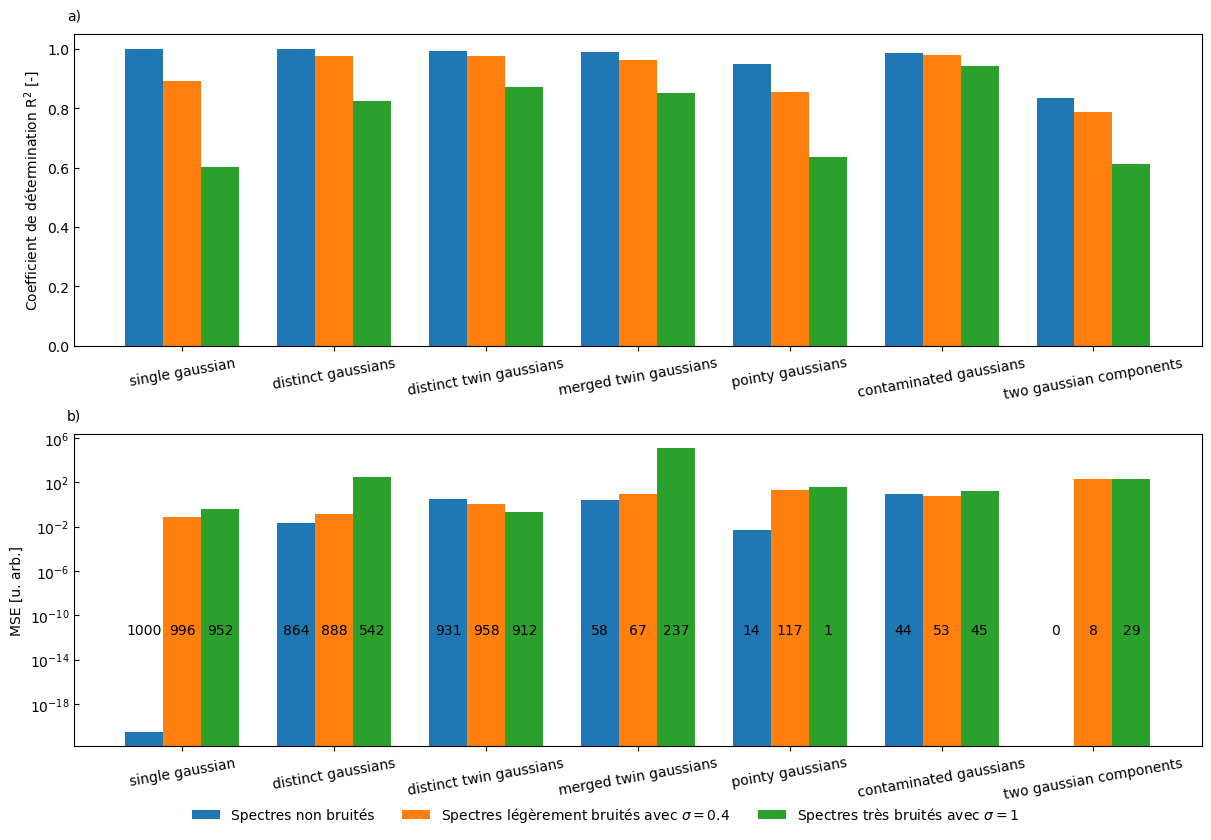

In [36]:
filenames = ["single_gaussian", "distinct_gaussians", "distinct_twin_gaussians", "merged_twin_gaussians", 
             "pointy_gaussians", "contaminated_gaussians", "two_gaussian_components"]
noise_levels = ["smooth", "noisy", "very_noisy"]

#data = {'smooth': {'distinct_gaussians': {'r2': 0.9989575224971305, 'mse': 0.022641208504663873, 'percentage': 86.4}, 'contaminated_gaussians': {'r2': 0.9854329919889203, 'mse': 8.073259491808225, 'percentage': 4.4}, 'distinct_twin_gaussians': {'r2': 0.9941798799475499, 'mse': 3.4265510978853944, 'percentage': 93.1}, 'merged_twin_gaussians': {'r2': 0.9883519773394316, 'mse': 2.5667517997002167, 'percentage': 5.8}, 'pointy_gaussians': {'r2': 0.9492687651177761, 'mse': 0.0046083761807328765, 'percentage': 1.4}, 'single_gaussian': {'r2': 0.9622949379574435, 'mse': 3.3333521654546976e-21, 'percentage': 96.9}, 'two_gaussian_components': {'r2': 0.8358144698411297, 'mse': np.nan, 'percentage': 0.0}}, 'noisy': {'distinct_gaussians': {'r2': 0.9749591585398732, 'mse': 0.13983796521887998, 'percentage': 88.8}, 'contaminated_gaussians': {'r2': 0.9792485319481634, 'mse': 5.492411474278277, 'percentage': 5.3}, 'distinct_twin_gaussians': {'r2': 0.9762845364348635, 'mse': 1.0241829164594074, 'percentage': 95.8}, 'merged_twin_gaussians': {'r2': 0.9615247574812141, 'mse': 8.723610618730063, 'percentage': 6.7}, 'pointy_gaussians': {'r2': 0.852987768472272, 'mse': 18.13366319700116, 'percentage': 11.7}, 'single_gaussian': {'r2': 0.8827375889874177, 'mse': 0.04272712258529626, 'percentage': 98.2}, 'two_gaussian_components': {'r2': 0.7877751402487843, 'mse': 212.5285761041905, 'percentage': 0.8}}, 'very_noisy': {'distinct_gaussians': {'r2': 0.8257678438322786, 'mse': 293.57624669240494, 'percentage': 54.2}, 'contaminated_gaussians': {'r2': 0.942700490569272, 'mse': 15.51401903770127, 'percentage': 4.5}, 'distinct_twin_gaussians': {'r2': 0.8730100400955949, 'mse': 0.20455440976642017, 'percentage': 91.2}, 'merged_twin_gaussians': {'r2': 0.8517149862040281, 'mse': 119371.2077723153, 'percentage': 23.7}, 'pointy_gaussians': {'r2': 0.6349620696556398, 'mse': 34.340087376859515, 'percentage': 0.1}, 'single_gaussian': {'r2': 0.5983426047458418, 'mse': 0.8790001902380394, 'percentage': 92.3}, 'two_gaussian_components': {'r2': 0.6105606063162168, 'mse': 181.42603389269672, 'percentage': 2.9}}}
data = {'smooth': {'distinct_gaussians': {'r2': 0.9989575224971305, 'mse': 0.022641208504663873, 'percentage': 86.4}, 'contaminated_gaussians': {'r2': 0.9854329919889203, 'mse': 8.073259491808225, 'percentage': 4.4}, 'distinct_twin_gaussians': {'r2': 0.9941798799475499, 'mse': 3.4265510978853944, 'percentage': 93.1}, 'merged_twin_gaussians': {'r2': 0.9883519773394316, 'mse': 2.5667517997002167, 'percentage': 5.8}, 'pointy_gaussians': {'r2': 0.9492687651177761, 'mse': 0.0046083761807328765, 'percentage': 1.4}, 'single_gaussian': {'r2': 1.0, 'mse': 3.3333520428706868e-21, 'percentage': 100.0}, 'two_gaussian_components': {'r2': 0.8358144698411297, 'mse': np.nan, 'percentage': 0.0}}, 'noisy': {'distinct_gaussians': {'r2': 0.9749591585398732, 'mse': 0.13983796521887998, 'percentage': 88.8}, 'contaminated_gaussians': {'r2': 0.9792485319481634, 'mse': 5.492411474278277, 'percentage': 5.3}, 'distinct_twin_gaussians': {'r2': 0.9762845364348635, 'mse': 1.0241829164594074, 'percentage': 95.8}, 'merged_twin_gaussians': {'r2': 0.9615247574812141, 'mse': 8.723610618730063, 'percentage': 6.7}, 'pointy_gaussians': {'r2': 0.8529964630690465, 'mse': 18.441268440219392, 'percentage': 11.7}, 'single_gaussian': {'r2': 0.8905253029165976, 'mse': 0.0764943638662448, 'percentage': 99.6}, 'two_gaussian_components': {'r2': 0.7877751402487845, 'mse': 212.5285761041905, 'percentage': 0.8}}, 'very_noisy': {'distinct_gaussians': {'r2': 0.8257678438322786, 'mse': 293.57624669240494, 'percentage': 54.2}, 'contaminated_gaussians': {'r2': 0.9427004788470725, 'mse': 15.52313179695461, 'percentage': 4.5}, 'distinct_twin_gaussians': {'r2': 0.8730100400955949, 'mse': 0.20455440976642017, 'percentage': 91.2}, 'merged_twin_gaussians': {'r2': 0.8517149862040281, 'mse': 119371.2077723153, 'percentage': 23.7}, 'pointy_gaussians': {'r2': 0.6349620696556398, 'mse': 34.340087376859515, 'percentage': 0.1}, 'single_gaussian': {'r2': 0.602284644424549, 'mse': 0.40761084529618863, 'percentage': 95.2}, 'two_gaussian_components': {'r2': 0.6105606063162168, 'mse': 181.42603389269672, 'percentage': 2.9}}}
new_data = {}
for noise_level in noise_levels:
    new_data[noise_level] = {}
    for spectrum in filenames:
        new_data[noise_level][spectrum] = {
            "r2": data[noise_level][spectrum]["r2"],
            "mse": data[noise_level][spectrum]["mse"] if data[noise_level][spectrum]["percentage"] >= 0 else 0,
            "percentage": data[noise_level][spectrum]["percentage"]
        }

data = new_data

# Create a bar plot
x = np.arange(len(filenames))  # Number of spectrum groups
width = 0.25  # Width of each bar

# --------------------

# Create a new figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 8), layout="constrained")

# Top plot: R²
axes[0].bar(x - width, [data["smooth"][spec]["r2"] for spec in filenames], width)
axes[0].bar(x, [data["noisy"][spec]["r2"] for spec in filenames],         width)
axes[0].bar(x + width, [data["very_noisy"][spec]["r2"] for spec in filenames], width)
axes[0].set_ylabel("Coefficient de détermination R$^2$ [-]")
axes[0].set_xticks(x)
axes[0].set_xticklabels([" ".join(file.split("_")) for file in filenames], rotation=10)
axes[0].tick_params(axis="y", direction="in")

# Bottom plot: MSE
axes[1].bar(x - width, [data["smooth"][spec]["mse"] for spec in filenames], width, label="Spectres non bruités")
axes[1].bar(x, [data["noisy"][spec]["mse"] for spec in filenames],         width, label=r"Spectres légèrement bruités avec $\sigma=0.4$")
axes[1].bar(x + width, [data["very_noisy"][spec]["mse"] for spec in filenames], width, label=r"Spectres très bruités avec $\sigma=1$")
axes[1].set_ylabel("MSE [u. arb.]")
axes[1].set_xticks(x)
axes[1].set_yscale("log")
#axes[1].set_ylim(1e-3, 5e2)
axes[1].set_xticklabels([" ".join(file.split("_")) for file in filenames], rotation=10)
axes[1].tick_params(axis="y", direction="in")

height = 1e-12
for i, (smooth, noisy, very_noisy) in enumerate(zip(
    [data["smooth"][spec]["percentage"] for spec in filenames],
    [data["noisy"][spec]["percentage"] for spec in filenames],
    [data["very_noisy"][spec]["percentage"] for spec in filenames]
)):
    axes[1].text(i - width, height, f"{int(smooth*10)}", ha="center", va="bottom", fontsize=10)
    axes[1].text(i, height, f"{int(noisy*10)}", ha="center", va="bottom", fontsize=10)
    axes[1].text(i + width, height, f"{int(very_noisy*10)}", ha="center", va="bottom", fontsize=10)

for ax, letter in zip(axes, ["a)", "b)"]):
    ax.text(
        0,
        1,
        letter,
        transform=ax.transAxes + ScaledTranslation(-5 / 72, 10 / 72, fig.dpi_scale_trans),
    )

# Create a general legend at the bottom
fig.legend(loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.04), frameon=False)

plt.savefig("projet/figures/sp_mse_r2_comparison.pdf", bbox_inches="tight", dpi=600)
plt.show()

# Fits of merged_twin_gaussians with the two DL methods

In [ ]:
np.random.seed(0)

SPEC_FILE = "merged_twin_gaussians/smooth"
N_SAMPLES = 200
cnn_fitter = CNNFitter.load(f"projet/data/neural_networks/CNNFitter/{SPEC_FILE.replace('/', '_')}.pt")
rn_fitter = ResNetFitter.load(f"projet/data/neural_networks/ResNetFitter/{SPEC_FILE.replace('/', '_')}.pt")

spec = Spectrum.load(f"projet/data/spectra/{SPEC_FILE}.txt")
dataset = SpectrumDataset.generate_from_spectrum(spec, N_SAMPLES)
data_loader = DataLoader(dataset, batch_size=1)

cnn_fits = cnn_fitter.predict(data_loader)
rn_fits = rn_fitter.predict(data_loader)

data = dataset.data.squeeze(1)
x_space = np.linspace(1, spec.number_of_channels, 1000)
plots = []
figs = []
for i, (spectrum, cnn_fit, rn_fit, params) in enumerate(zip(data, cnn_fits, rn_fits, dataset.params)):
    if i not in [12, 21, 63]:
        continue
    plottables = [
        gl.Curve(x_space, spec(x_space, params), label="Données réelles" if i == 12 else None, color="black"),
        gl.Curve(x_space, spec.models[0](x_space, *params[0].numpy()), color="black"),
        gl.Curve(x_space, spec.models[1](x_space, *params[1].numpy()), color="black"),
        gl.Curve(x_space, spec(x_space, cnn_fit), label="Prédictions du CNNFitter" if i == 12 else None, 
                 color="red", line_style=":"),
        gl.Curve(x_space, spec.models[0](x_space, *cnn_fit[0].numpy()), color="red", line_style=":"),
        gl.Curve(x_space, spec.models[1](x_space, *cnn_fit[1].numpy()), color="red", line_style=":"),
        gl.Curve(x_space, spec(x_space, rn_fit), label="Prédictions du ResNetFitter" if i == 12 else None, 
                 color="limegreen", line_style=":"),
        gl.Curve(x_space, spec.models[0](x_space, *rn_fit[0].numpy()), color="limegreen", line_style=":"),
        gl.Curve(x_space, spec.models[1](x_space, *rn_fit[1].numpy()), color="limegreen", line_style=":"),
    ]

    # show_plot(*plottables)
    plots.append(plottables)
    fig = gl.Figure()
    fig.add_elements(*plottables)
    figs.append(fig)

figs[1].x_axis_name=  "Numéro du canal [-]"
multifig = gl.MultiFigure.from_row(size=(12, 4), figures=figs)
multifig.y_label = "Intensité [u. arb.]"
# fig = SmartFigure(1, 3, size=(12, 4), x_label="Numéro du canal [-]", y_label="Intensité [u. arb.]", elements=plots)
multifig.show(general_legend=True, legend_cols=3)#, legend_loc="lower center")
multifig.save("projet/figures/merged_twin_gaussians_fits.pdf", dpi=600)

# Learning curves
Performed on the contaminated_gaussians/noisy dataset

In [ ]:
cnn_train_loss = [13.758895954390367, 0.24408205818384887, 0.15084399813786148, 0.11098555898914735, 0.09210927356034518, 0.08038803949331244, 0.0725375143904239, 0.06751596283788483, 0.06404577823976676, 0.06095873625949025, 0.05838800764332215, 0.05658437949294845, 0.054963169399028025, 0.05349917958800991, 0.052176554687321186, 0.05116773274416725, 0.050159493184958895, 0.04940330196792881, 0.048646419616416095, 0.04792731018116077, 0.0472824376107504, 0.04649519307228426, 0.04611464393946032, 0.0454070757360508, 0.04487739471408228]
cnn_validation_loss = [0.31936368644237517, 0.1817370191216469, 0.1221340425312519, 0.09033381938934326, 0.08466209918260574, 0.07081382274627686, 0.06401797235012055, 0.06328292861580849, 0.05920785441994667, 0.05943334773182869, 0.06039174273610115, 0.05328611396253109, 0.05386771112680435, 0.048015312477946284, 0.045614556223154065, 0.04707428924739361, 0.044473414123058316, 0.04517862126231194, 0.045216677337884904, 0.04641066007316112, 0.04543603286147117, 0.043743275478482245, 0.043900667876005176, 0.04137436747550964, 0.04323725886642933]

resnet_train_loss = [4.7417942417226735, 0.04618736562939982, 0.04277121901822587, 0.04469357507303357, 0.0453660530426229, 0.04535958195260415, 0.04452252529406299, 0.04332853215901802, 0.0424025622010231, 0.04153394157066941, 0.04081687022000551, 0.04016980287618935, 0.039538920565197866, 0.03893346661546578, 0.0384537695767358, 0.037935288071942824, 0.03754682020439456, 0.037163686070901654, 0.03680047240418693, 0.03645477579285701, 0.03613624487072229, 0.03588601673953235, 0.03562690668584158, 0.035353735846777756, 0.03509020960424095]
resnet_validation_loss = [0.048163417354226114, 0.03817449249327183, 0.03563809245824814, 0.041671404615044594, 0.0407627534121275, 0.039077417179942134, 0.037369074672460555, 0.03945320919156074, 0.03579188548028469, 0.0351521972566843, 0.03448932245373726, 0.034866294264793395, 0.03408081904053688, 0.03281133472919464, 0.03183426931500435, 0.031726441159844396, 0.03069988079369068, 0.03059649020433426, 0.030257757380604745, 0.030541950650513173, 0.03046640772372484, 0.031168662011623383, 0.031463134288787845, 0.03141533713787794, 0.031441043317317965]

fig = gl.Figure(x_label="Époque [-]", y_label="MSE [u. arb.]", log_scale_y=True, size=(8,4))
epochs = np.arange(len(cnn_train_loss)) + 1
fig.add_elements(
    gl.Curve(epochs, cnn_train_loss, label="CNNFitter - Entrainement", color="red"),
    gl.Curve(epochs, cnn_validation_loss, label="CNNFitter - Validation", color="red", line_style=":"),
    gl.Curve(epochs, resnet_train_loss, label="ResNetFitter - Entrainement", color="limegreen"),
    gl.Curve(epochs, resnet_validation_loss, label="ResNetFitter - Validation", color="limegreen", line_style=":"),
)
fig.show()
# fig.save("projet/figures/learning_curve_different_models.pdf", dpi=600)

The following figure is performed on the single_gaussian/noisy dataset

In [ ]:
# Learning rate 1e-4
train_loss_4 = [23.663483922481536, 0.23140060689300299, 0.14689905997365713, 0.1166658089744548, 0.10274196582225462, 0.09445970499577622, 0.08888452812408408, 0.08498591374605895, 0.08212201616105934, 0.07994605678444107, 0.07828620896364252, 0.07697232223736743, 0.07589891483696798, 0.0750206613074988, 0.07426215960954627, 0.07362214437685907, 0.0730508501517276, 0.07253459422538677, 0.07207057434134186, 0.07165785999658207, 0.07127911985851824, 0.07092867585519949, 0.0706069718580693, 0.07030681820896764, 0.07000853397573034, 0.06974512100530167, 0.0694902453571558, 0.06925563752030332, 0.06901476695512732, 0.06880000904512902, 0.06859353576165934, 0.06839663910058637, 0.0682026774995029, 0.06802228295865158, 0.06784897207903365, 0.06768843113134304, 0.06752496012176076, 0.06737720914185047, 0.06723004573645691, 0.06708660058677196, 0.06694986572799583, 0.06681347887963057, 0.06668506757356227, 0.06655701161672671, 0.06643179474088053, 0.06630919442822536, 0.06619600650233527, 0.06607760151227315, 0.0659655513583372, 0.06585399616820117]
validation_loss_4 = [0.3237897723913193, 0.16926805526018143, 0.1228762373328209, 0.09999878183007241, 0.08924771547317505, 0.08553482741117477, 0.08378478959202766, 0.08132389932870865, 0.07888012379407883, 0.07732055634260178, 0.07597735077142716, 0.07478933930397033, 0.07369653582572937, 0.0728887178003788, 0.07213450521230698, 0.07163532972335815, 0.07090697064995766, 0.07030805498361588, 0.06984521746635437, 0.06951616704463959, 0.06945009380578995, 0.0692578412592411, 0.06903453394770623, 0.06894670650362969, 0.06887729093432426, 0.06885681450366973, 0.06884848698973656, 0.06854377537965775, 0.06829900443553924, 0.06822852715849877, 0.06800245642662048, 0.06794576719403267, 0.0677643321454525, 0.06770416423678398, 0.06763991825282574, 0.06765725910663604, 0.06772121116518974, 0.06784299239516259, 0.06787441447377204, 0.0678401067852974, 0.06791941300034524, 0.06800044402480125, 0.06801677495241165, 0.06809675619006157, 0.06811233833432198, 0.0680904246866703, 0.06822850778698922, 0.06839232444763184, 0.0685362197458744, 0.06849573031067849]

# Learning rate 1e-3
train_loss_3 = [3.188322921215246, 0.11750801021854083, 0.11312232319576045, 0.10890939484039942, 0.10633931175805628, 0.10064554633262257, 0.09661000701288382, 0.09398663693728547, 0.09098614410186807, 0.08838448422960937, 0.08601849351388713, 0.0844099960786601, 0.08310070937809845, 0.08211608201265336, 0.08090050016529858, 0.07996655656645696, 0.07916803196072579, 0.0783614569529891, 0.07754672278650104, 0.07680630714943011, 0.07606969073414803, 0.07533274999509255, 0.07469938977000613, 0.07406353286777934, 0.07350010499668617, 0.07293783774288992, 0.07255346288283666, 0.07212628330414494, 0.07192072990039984, 0.07149824742848675, 0.07108600586963197, 0.0706042868923396, 0.0701493144625177, 0.06971760513881842, 0.06929927445016801, 0.06887529198390742, 0.06842084239857892, 0.0678945720444123, 0.06743363643065095, 0.06692744209120671, 0.06646466429034868, 0.06602276709551612, 0.06545414735252658, 0.06489745610083143, 0.06461587234400212, 0.06404556499173243, 0.06355381229271491, 0.06304258569764594, 0.06286960107274353, 0.06223511615457634]
validation_loss_3 = [0.11381165683269501, 0.10138759687542916, 0.0900663398206234, 0.12351007834076881, 0.11880558878183364, 0.12560932859778404, 0.10957062318921089, 0.1017148956656456, 0.08193250671029091, 0.08266349285840988, 0.07930131182074547, 0.07817668840289116, 0.0739750824868679, 0.07561806738376617, 0.07234745472669601, 0.07331183478236199, 0.07055437117815018, 0.06768143475055695, 0.0676129013299942, 0.06903366446495056, 0.06800661608576775, 0.06730826199054718, 0.0671122208237648, 0.06630868427455425, 0.06623762138187886, 0.06637011878192425, 0.06593629866838455, 0.06593293584883213, 0.06643884479999543, 0.0663143366575241, 0.06666277423501014, 0.06723954752087594, 0.06759974732995033, 0.066801418364048, 0.06689024269580841, 0.06785210072994233, 0.0677866093814373, 0.06792303323745727, 0.06714258417487144, 0.06763081550598145, 0.06972831040620804, 0.06855265200138091, 0.0690811075270176, 0.06877303048968315, 0.07041767314076423, 0.07164874821901321, 0.07114441692829132, 0.07286003530025482, 0.07275554239749908, 0.0757073774933815]

# Learning rate 1e-2
train_loss_2 = [2.5335007942343752, 0.1915275571371118, 0.2511098799171547, 0.2360844618206223, 0.18997038203602035, 0.15470456382259726, 0.13930552837749322, 0.12911584713496269, 0.11962442361749709, 0.1146995661749194, 0.11041285502103468, 0.1054224544359992, 0.10143163253863653, 0.0983144504763186, 0.09582411931827664, 0.09480053189521034, 0.0912606308919688, 0.0897923532469819, 0.08746671620445946, 0.08538399303331971, 0.08361897904115419, 0.08244250615748266, 0.08132236149162055, 0.08060057590405147, 0.07943654109413426, 0.07892628366438051, 0.07818111122585833, 0.07738422375793258, 0.07663786415942013, 0.07611661025633415, 0.07588162710269292, 0.07574251142330468, 0.07611333413670461, 0.07542932687948148, 0.0752547554920117, 0.07515463056663672, 0.07482430499978364, 0.07456894061528146, 0.07424526781464616, 0.07413525742478669, 0.07410343224493166, 0.0738161129442354, 0.07353303962076704, 0.07332275997847319, 0.07305639017062883, 0.07301234467265506, 0.07251931359370549, 0.07235260333244999, 0.07216675072908402, 0.07209435736760497]
validation_loss_2 = [0.26105038821697235, 0.24594816118478774, 0.315421062707901, 0.15044306069612504, 0.11354292780160904, 0.10410498827695847, 0.15374322831630707, 0.14350362569093705, 0.1666252002120018, 0.13039868623018264, 0.11838550716638566, 0.11241372004151344, 0.12768203765153885, 0.09019664898514748, 0.07526389956474304, 0.08475199192762375, 0.07030088230967521, 0.07373495250940323, 0.0811210699379444, 0.07891006767749786, 0.0728171281516552, 0.07475061491131782, 0.07278073951601982, 0.07633727192878723, 0.0719831869006157, 0.08593194112181664, 0.0799633465707302, 0.08139245882630348, 0.08398458883166313, 0.09300019517540932, 0.08639754876494407, 0.08972752690315247, 0.09913085475564003, 0.10374790802598, 0.09548489451408386, 0.10317086055874825, 0.09800498113036156, 0.09519598856568337, 0.09788624793291092, 0.09586451724171638, 0.09964804500341415, 0.09174861684441567, 0.08469294682145119, 0.0772219493985176, 0.08353695794939994, 0.08670685291290284, 0.07646745666861535, 0.07647917047142982, 0.09705446138978005, 0.08472377061843872]

fig = gl.Figure(x_label="Époque [-]", y_label="MSE [u. arb.]", log_scale_y=True, size=(8, 4))
fig.add_elements(
    gl.Curve(epochs, validation_loss_2, label="Taux d'apprentisage de 0.01"),
    gl.Curve(epochs, validation_loss_3, label="Taux d'apprentisage de 0.001"),
    gl.Curve(epochs, validation_loss_4, label="Taux d'apprentisage de 0.0001"),
)
fig.show()
# fig.sae("projet/figures/learning_curve_different_lr.pdf", dpi=600)